<a href="https://colab.research.google.com/github/Yevheniia-Ilchenko/ML_DS_tasks/blob/main/HW_2_4_%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC%D0%B8_%D0%B1%D1%83%D1%81%D1%82%D0%B8%D0%BD%D0%B3%D1%83.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням алгоритмів бустингу: XGBoost та LightGBM, а також використаємо бібліотеку HyperOpt для оптимізації гіперпараметрів.

0. Зчитайте дані `train.csv` в змінну `raw_df` та скористайтесь наведеним кодом нижче аби розділити дані на трнувальні та валідаційні і розділити дані на ознаки з матириці Х та цільову змінну. Назви змінних `train_inputs, train_targets, train_inputs, train_targets` можна змінити на ті, які Вам зручно.

  Наведений скрипт - частина отриманого мною скрипта для обробки даних. Ми тут не викнуємо масштабування та обробку категоріальних змінних, бо хочемо це делегувати алгоритмам, які будемо використовувати. Якщо щось не розумієте в наведених скриптах, рекомендую розібратись: навичка читати код - важлива складова роботи в машинному навчанні.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from typing import Tuple, Dict, Any


def split_train_val(df: pd.DataFrame, target_col: str, test_size: float = 0.2, random_state: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split the dataframe into training and validation sets.

    Args:
        df (pd.DataFrame): The raw dataframe.
        target_col (str): The target column for stratification.
        test_size (float): The proportion of the dataset to include in the validation split.
        random_state (int): Random state for reproducibility.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: Training and validation dataframes.
    """
    train_df, val_df = train_test_split(df, test_size=test_size, random_state=random_state, stratify=df[target_col])
    return train_df, val_df


def separate_inputs_targets(df: pd.DataFrame, input_cols: list, target_col: str) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Separate inputs and targets from the dataframe.

    Args:
        df (pd.DataFrame): The dataframe.
        input_cols (list): List of input columns.
        target_col (str): Target column.

    Returns:
        Tuple[pd.DataFrame, pd.Series]: DataFrame of inputs and Series of targets.
    """
    inputs = df[input_cols].copy()
    targets = df[target_col].copy()
    return inputs, targets

In [ ]:
raw_df = pd.read_csv("/content/train.csv", index_col=0)

In [ ]:
raw_df.drop(columns=['CustomerId', 'Surname'], inplace=True)

In [ ]:
target_cols = raw_df.columns[-1]
target_cols

'Exited'

In [ ]:
input_cols = raw_df.columns[0:-1]
input_cols

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'],
      dtype='object')

In [ ]:
train_df, val_df = split_train_val(raw_df, target_cols)

In [ ]:
train_inputs, train_targets = separate_inputs_targets(train_df, input_cols, target_cols)

In [ ]:
val_inputs, val_targets = separate_inputs_targets(val_df, input_cols, target_cols)

1. В тренувальному та валідаційному наборі перетворіть категоріальні ознаки на тип `category`. Можна це зробити двома способами:
 1. `df[col_name].astype('category')`, як було продемонстровано в лекції
 2. використовуючи метод `pd.Categorical(df[col_name])`

In [ ]:
train_inputs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12000 entries, 7180 to 9360
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      12000 non-null  float64
 1   Geography        12000 non-null  object 
 2   Gender           12000 non-null  object 
 3   Age              12000 non-null  float64
 4   Tenure           12000 non-null  float64
 5   Balance          12000 non-null  float64
 6   NumOfProducts    12000 non-null  float64
 7   HasCrCard        12000 non-null  float64
 8   IsActiveMember   12000 non-null  float64
 9   EstimatedSalary  12000 non-null  float64
dtypes: float64(8), object(2)
memory usage: 1.0+ MB


In [ ]:
cat_features = train_inputs.select_dtypes(include='object').columns
cat_features

Index(['Geography', 'Gender'], dtype='object')

In [ ]:
test = pd.read_csv('/content/test.csv', index_col=0)

In [ ]:
train_inputs[cat_features] = train_inputs[cat_features].astype('category')
val_inputs[cat_features] = val_inputs[cat_features].astype('category')
test[cat_features] = test[cat_features].astype('category')

In [ ]:
train_inputs.dtypes

,0
CreditScore,float64
Geography,category
Gender,category
Age,float64
Tenure,float64
Balance,float64
NumOfProducts,float64
HasCrCard,float64
IsActiveMember,float64
EstimatedSalary,float64


2. Навчіть на отриманих даних модель `XGBoostClassifier`. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів XGBoostClassifier - тут https://xgboost.readthedocs.io/en/stable/parameter.html#global-config

  **Важливо:** зробіть такі налаштування `XGBoostClassifier` аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Можна також, якщо працюєте в Google Colab, увімкнути можливість використання GPU (`Runtime -> Change runtime type -> T4 GPU`) і встановити параметр `device='cuda'` в `XGBoostClassifier` для пришвидшення тренування бустинг моделі.
  
  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням DecisionTrees раніше. Чи вийшло покращити якість?

In [ ]:
from xgboost import XGBClassifier

In [ ]:
xgb_clf = XGBClassifier(
    max_depth=3,
    n_estimators=25,
    enable_categorical=True,
    missing=np.nan,
    device='cuda'
)
xgb_clf.fit(train_inputs, train_targets)

train_pred = xgb_clf.predict(train_inputs)
val_pred = xgb_clf.predict(val_inputs)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:00:21] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, auc

def compute_auroc_and_build_roc(model, inputs, targets, name=''):
  y_pred_proba = model.predict_proba(inputs)[:, 1]
  fpr, tpr, thresholds = roc_curve(targets, y_pred_proba)
  roc_auc = auc(fpr, tpr)
  print(f'AUROC for {name}: {roc_auc:.4f}')

In [ ]:
compute_auroc_and_build_roc(xgb_clf, train_inputs, train_targets, 'Training')
compute_auroc_and_build_roc(xgb_clf, val_inputs, val_targets, 'Validation')

AUROC for Training: 0.9409
AUROC for Validation: 0.9377


В цілому модель гарна, в порівнянні з DT дала кращий результат,
трохи помічається hight variаnce

3. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `XGBoostClassifier` з лекції знайдіть оптимальні значення гіперпараметрів `XGBoostClassifier` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **20**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. В ній ми маємо задати loss - це може будь-яка метрика, але бажано використовувтаи ту, яка цільова в вашій задачі. Чим менший лосс - тим ліпша модель на думку hyperopt. Тож, тут нам треба задати loss - негативне значення AUROC. В лекції ми натомість використовували Accuracy.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_clf` модель `XGBoostClassifier` з найкращими гіперпараметрами
    - навчіть модель `final_clf`
    - оцініть якість моделі `final_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (2) цього завдання?

In [ ]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [ ]:
def objective(params):
    clf = xgb.XGBClassifier(
        n_estimators=int(params['n_estimators']),
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        min_child_weight=params['min_child_weight'],  # Мінімальна сума ваг всіх вибірок, необхідна в кінцевому вузлі
        subsample=params['subsample'],  # Частка вибірок, що використовуються для побудови кожного дерева
        colsample_bytree=params['colsample_bytree'],  # Частка ознак, що використовуються при побудові кожного дерева
        gamma=params['gamma'],  # Мінімальне зменшення втрат, необхідне для виконання поділу
        reg_alpha=params['reg_alpha'],  # Параметр регуляризації L1 (Lasso)
        reg_lambda=params['reg_lambda'],  # Параметр регуляризації L2 (Ridge)
        enable_categorical=True,
        use_label_encoder=False,
        missing=np.nan,
        device='cuda',
        early_stopping_rounds=10
    )

    clf.fit(
        train_inputs,
        train_targets,
        eval_set=[(val_inputs, val_targets)],
        verbose=False)
    y_pred_proba = clf.predict_proba(val_inputs)[:, 1]
    fpr, tpr, thresholds = roc_curve(val_targets, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    return {'loss': -roc_auc, 'status': STATUS_OK}

# Простір гіперпараметрів
space = {
    'n_estimators': hp.quniform('n_estimators', 20, 200, 10),
    'learning_rate': hp.uniform('learning_rate', 0.1, 0.3),
    'max_depth': hp.quniform('max_depth', 2, 15, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'gamma': hp.uniform('gamma', 0, 0.5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1)
}

# Оптимізація
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)

# Перетворення значень гіперпараметрів у кінцеві типи
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['min_child_weight'] = int(best['min_child_weight'])

print("Найкращі гіперпараметри: ", best)

# Навчання фінальної моделі з найкращими гіперпараметрами
final_clf = xgb.XGBClassifier(
    n_estimators=best['n_estimators'],
    learning_rate=best['learning_rate'],
    max_depth=best['max_depth'],
    min_child_weight=best['min_child_weight'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    gamma=best['gamma'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    enable_categorical=True,
    missing=np.nan,
    device='cuda',
)

final_clf.fit(train_inputs, train_targets)
final_pred = final_clf.predict(val_inputs)
final_pred_train = final_clf.predict(train_inputs)

y_pred_proba = final_clf.predict_proba(val_inputs)[:, 1]
y_pred_proba_train = final_clf.predict_proba(train_inputs)[:, 1]

fpr_train, tpr_train, thresholds_train = roc_curve(val_targets, y_pred_proba)
final_roc_auc = auc(fpr_train, tpr_train)

fpr, tpr, thresholds = roc_curve(train_targets, y_pred_proba_train)
final_roc_auc_train = auc(fpr, tpr)

print("Точність на валідаційній вибірці: {:.4f}".format(final_roc_auc))
print("Точність на тренувальній вибірці: {:.4f}".format(final_roc_auc_train))

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:02:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 10%|█         | 2/20 [00:00<00:03,  4.75trial/s, best loss: -0.9370447218602099]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:02:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:02:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 15%|█▌        | 3/20 [00:00<00:03,  4.87trial/s, best loss: -0.9382104396735029]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:02:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 25%|██▌       | 5/20 [00:01<00:03,  4.71trial/s, best loss: -0.9382104396735029]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:02:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:02:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 35%|███▌      | 7/20 [00:01<00:02,  5.03trial/s, best loss: -0.9382104396735029]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:02:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:02:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 45%|████▌     | 9/20 [00:01<00:02,  4.73trial/s, best loss: -0.9382104396735029]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:02:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:02:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 55%|█████▌    | 11/20 [00:02<00:01,  5.62trial/s, best loss: -0.9382104396735029]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:02:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:02:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 65%|██████▌   | 13/20 [00:02<00:01,  5.75trial/s, best loss: -0.9382104396735029]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:02:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:02:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 75%|███████▌  | 15/20 [00:03<00:00,  5.15trial/s, best loss: -0.9382104396735029]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:02:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:02:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 85%|████████▌ | 17/20 [00:03<00:00,  5.53trial/s, best loss: -0.9382104396735029]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:02:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:02:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 95%|█████████▌| 19/20 [00:03<00:00,  5.19trial/s, best loss: -0.9382104396735029]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:02:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:02:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



100%|██████████| 20/20 [00:03<00:00,  5.11trial/s, best loss: -0.9382104396735029]
Найкращі гіперпараметри:  {'colsample_bytree': 0.9447969270516366, 'gamma': 0.24792360578320372, 'learning_rate': 0.1706553915178362, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 70, 'reg_alpha': 0.22614890685582378, 'reg_lambda': 0.7109507081547856, 'subsample': 0.7994371867716125}
Точність на валідаційній вибірці: 0.9374
Точність на тренувальній вибірці: 0.9436


Точність на валідаційній вибірці: 0.9374 трохи нижча ніж в попередньому завданні




4. Навчіть на наших даних модель LightGBM. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів LightGBM - тут https://lightgbm.readthedocs.io/en/latest/Parameters.html

  **Важливо:** зробіть такі налаштування LightGBM аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Аби передати категоріальні колонки в LightGBM - необхідно виявити їх індекси і передати в параметрі `cat_feature=cat_feature_indexes`

  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням XGBoostClassifier раніше. Чи вийшло покращити якість?

In [ ]:
import lightgbm as lgb
print(lgb.__version__)

4.5.0


In [ ]:
cat_feature_indexes = [train_inputs.columns.get_loc(col) for col in cat_features]

In [ ]:
lgb_clf = lgb.LGBMClassifier(
    max_depth=3,
    n_estimators=100,
    learning_rate=0.1,
    cat_feature=cat_feature_indexes,
    missing=np.nan,
)

lgb_clf.fit(train_inputs, train_targets, eval_set=[(val_inputs, val_targets)])

train_pred = lgb_clf.predict(train_inputs)
val_pred = lgb_clf.predict(val_inputs)

y_pred_proba = lgb_clf.predict_proba(val_inputs)[:, 1]
y_pred_proba_train = lgb_clf.predict_proba(train_inputs)[:, 1]

fpr_train, tpr_train, thresholds_train = roc_curve(val_targets, y_pred_proba)
final_roc_auc = auc(fpr_train, tpr_train)

fpr, tpr, thresholds = roc_curve(train_targets, y_pred_proba_train)
final_roc_auc_train = auc(fpr, tpr)

print("Точність на валідаційній вибірці: {:.4f}".format(final_roc_auc))
print("Точність на тренувальній вибірці: {:.4f}".format(final_roc_auc_train))

[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Warning] categorical_feature is set with cat_feature=1,2, categorical_column=1,2 will be ignored. Current value: categorical_feature=1,2
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001506 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 843
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 10
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203500 -> initscore=-1.364561
[LightGBM] [Info] Start training from score -1.364561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

Точність на валідаційній вибірці: 0.9377
Точність на тренувальній вибірці: 0.9437

Модель непогана, помічається трохи high variance

Майже такі ж значення чк і в XGB без оптимізації гіперпараметрів

5. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `LightGBM` з лекції знайдіть оптимальні значення гіперпараметрів `LightGBM` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **10**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. І тут ми також ставимо loss - негативне значення AUROC, як і при пошуці гіперпараметрів для XGBoost. До речі, можна спробувати написати код так, аби в objective передавати лише модель і не писати схожий код двічі :)

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_lgb_clf` модель `LightGBM` з найкращими гіперпараметрами
    - навчіть модель `final_lgb_clf`
    - оцініть якість моделі `final_lgb_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (4) цього завдання?

In [ ]:
def objective(params):
    clf = lgb.LGBMClassifier(
        n_estimators=int(params['n_estimators']),  # Кількість дерев у ансамблі (кількість ітерацій бустингу)
        learning_rate=params['learning_rate'],  # Коефіцієнт, на який зменшується внесок кожного доданого дерева
        max_depth=int(params['max_depth']),  # Максимальна глибина кожного дерева
        num_leaves=int(params['num_leaves']),  # Максимальна кількість листків, що дозволяємо кожному дереву мати.
        min_child_weight=params['min_child_weight'],  # Мінімальна сума ваг всіх вибірок, необхідна в кінцевому вузлі
        subsample=params['subsample'],  # Частка вибірок, що використовуються для побудови кожного дерева
        colsample_bytree=params['colsample_bytree'],  # Частка ознак, що використовуються при побудові кожного дерева
        reg_alpha=params['reg_alpha'],  # Параметр регуляризації L1 (Lasso)
        reg_lambda=params['reg_lambda'],  # Параметр регуляризації L2 (Ridge)
        min_split_gain=params['min_split_gain'],  # Мінімальне зменшення втрат, необхідне для виконання поділу
        cat_feature=cat_feature_indexes  # Індекси категорійних ознак
    )

    clf.fit(train_inputs, train_targets, eval_set=[(val_inputs, val_targets)])
    pred = clf.predict(val_inputs)
    y_pred_proba = clf.predict_proba(val_inputs)[:, 1]
    fpr, tpr, thresholds = roc_curve(val_targets, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    return {'loss': -roc_auc, 'status': STATUS_OK}


# Простір гіперпараметрів
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 10),
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.3),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'min_split_gain': hp.uniform('min_split_gain', 0, 0.1)
}

# Оптимізація
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)

# Перетворення значень гіперпараметрів у кінцеві типи
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['num_leaves'] = int(best['num_leaves'])
best['min_child_weight'] = int(best['min_child_weight'])

print("Найкращі гіперпараметри: ", best)

# Навчання фінальної моделі з найкращими гіперпараметрами
final_clf = lgb.LGBMClassifier(
    n_estimators=best['n_estimators'],
    learning_rate=best['learning_rate'],
    max_depth=best['max_depth'],
    num_leaves=best['num_leaves'],
    min_child_weight=best['min_child_weight'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    min_split_gain=best['min_split_gain'],
    cat_feature=cat_feature_indexes,
    missing=np.nan
)

final_clf.fit(train_inputs, train_targets, eval_set=[(val_inputs, val_targets)])
final_pred = final_clf.predict(val_inputs)
final_pred_train = final_clf.predict(train_inputs)

y_pred_proba = final_clf.predict_proba(val_inputs)[:, 1]
y_pred_proba_train = final_clf.predict_proba(train_inputs)[:, 1]

fpr_train, tpr_train, thresholds_train = roc_curve(val_targets, y_pred_proba)
final_roc_auc = auc(fpr_train, tpr_train)

fpr, tpr, thresholds = roc_curve(train_targets, y_pred_proba_train)
final_roc_auc_train = auc(fpr, tpr)

print("Точність на валідаційній вибірці: {:.4f}".format(final_roc_auc))
print("Точність на тренувальній вибірці: {:.4f}".format(final_roc_auc_train))

[LightGBM] [Warning] categorical_feature is set with cat_feature=1,2, categorical_column=1,2 will be ignored. Current value: categorical_feature=1,2
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 843
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203500 -> initscore=-1.364561
[LightGBM] [Info] Start training from score -1.364561
[LightGBM] [Warning] categorical_feature is set with cat_feature=1,2, categorical_column=1,2 will be ignored. Current value: categorical_feature=1,2
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of test

Точність на валідаційній вибірці: 0.9357
Точність на тренувальній вибірці: 0.9485

Ні модель не стала краще за попередню але дуже наближена

6. Оберіть модель з експериментів в цьому ДЗ і зробіть новий `submission` на Kaggle та додайте код для цього і скріншот скора на публічному лідерборді.
  
  **Напишіть коментар, чому ви обрали саме цю модель?**

  І я вас вітаю - це останнє завдання з цим набором даних 💪 На цьому етапі корисно проаналізувати, які моделі показали себе найкраще і подумати, чому.

In [ ]:
test.drop(columns=['CustomerId', 'Surname'], inplace=True)

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 15000 to 24999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   CreditScore      10000 non-null  float64 
 1   Geography        10000 non-null  category
 2   Gender           10000 non-null  category
 3   Age              10000 non-null  float64 
 4   Tenure           10000 non-null  float64 
 5   Balance          10000 non-null  float64 
 6   NumOfProducts    10000 non-null  float64 
 7   HasCrCard        10000 non-null  float64 
 8   IsActiveMember   10000 non-null  float64 
 9   EstimatedSalary  10000 non-null  float64 
dtypes: category(2), float64(8)
memory usage: 722.9 KB


In [ ]:
test_pred = xgb_clf.predict(test)
test_pred_proba = xgb_clf.predict_proba(test)[:, 1]
test_pred_proba

array([0.07431886, 0.02154193, 0.05477314, ..., 0.00706185, 0.06510583,
       0.16896841], dtype=float32)

In [ ]:
sample = pd.read_csv("/content/sample_submission.csv", index_col=0)
sample.drop(columns="Exited")

""
id
15000
15001
15002
15003
15004
...
24995
24996
24997


In [ ]:
sample["Exited"] = test_pred_proba
sample.to_csv("submission.csv")

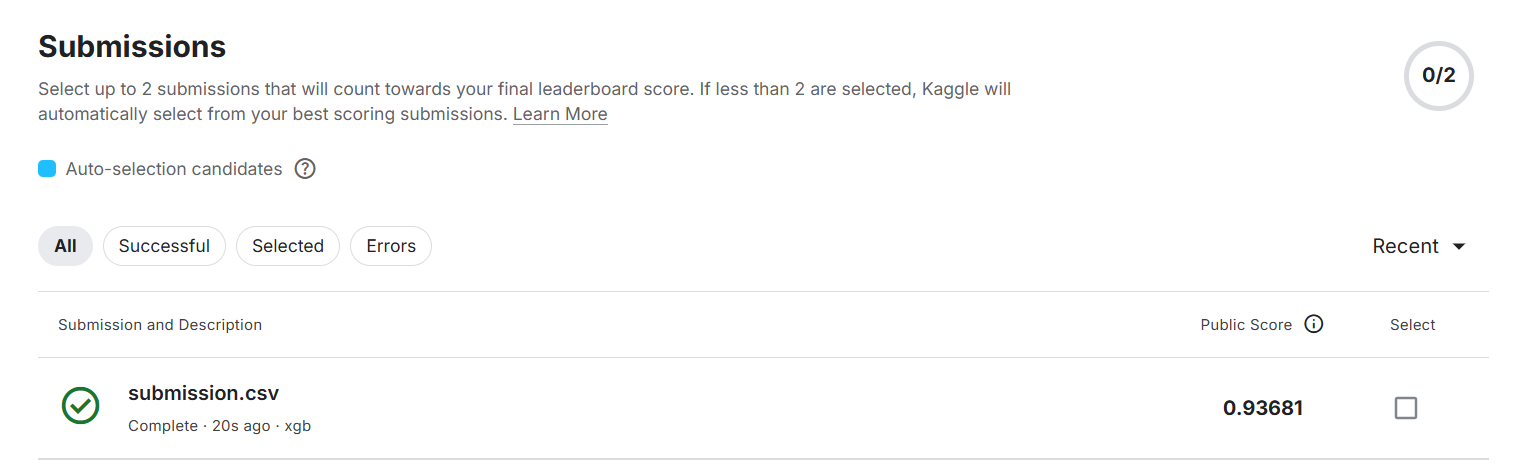

Обрала цю модель, бо вона дає найкращий результат при цьому сама по собі не складна і не важко налаштовувати.

Ще поекспериментую з налаштуваннями, але впевнена що важливо також вміти балансувати між складністю моделі та її предіктом